In [1]:
import numpy as np
from numba import njit, prange
import csv
import os
import pandas as pd
from glob import glob
import time
import matplotlib.pyplot as plt
from src import functions
import scipy.stats as sc
import shutil
from sklearn.cluster import DBSCAN


ModuleNotFoundError: No module named 'src'

In [134]:
# Import all files (cell zones) under one experiment type, but for both dep and spon vesicle targets
# Imported file names are printed

target_marker = 'PSD680'

target_directory = '/Volumes/STORM_Nathalie/STORM DeMixing/'
list_of_files = np.array([file for file in glob(target_directory + f'*{target_marker}*/*/*emix/*w*.csv')])
try:
    list_of_files = list_of_files.reshape(list_of_files.shape[0]//2,2)
except ValueError:
    print('Value Error: one channel is missing from one of the cellzones.')

zone_nb = list_of_files.shape[0]

print("shape", list_of_files.shape)

shape (54, 2)


In [135]:
#choosing data for DBScan 

ex_zone = ['/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w1_UncertaintyFiltered.csv',
  '/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w2_UncertaintyFiltered.csv']

vesicles = pd.read_csv(ex_zone[0])[['x [nm]', 'y [nm]', 'z [nm]', 'intensity [photon]']].to_numpy(dtype=np.float64)
synapse_marker = pd.read_csv(ex_zone[1])[['x [nm]', 'y [nm]', 'z [nm]', 'intensity [photon]']].to_numpy(dtype=np.float64)


53.59768591057008


% points above threshold: 53.59768591057008


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


number of clusters: 50


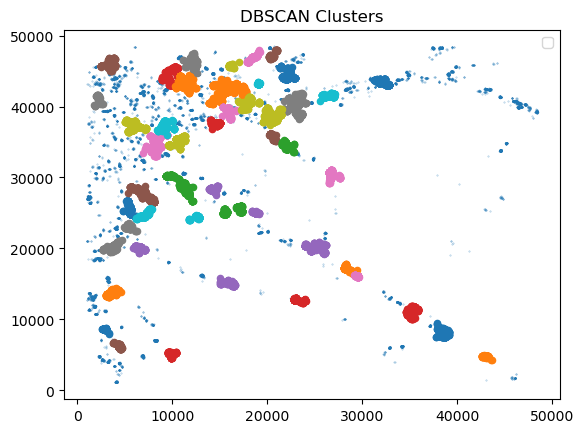

<Figure size 640x480 with 0 Axes>

In [166]:
#define intensity threshold. Points which have a lower intensity will be excluded from the clustering.
int_threshold=1200

#apply the threshold on the vesicle and synaptic marker datasets
vesicles_thresh = vesicles[vesicles[:,3]>int_threshold,0:3]
synapse_marker_thresh = synapse_marker[synapse_marker[:,3]>int_threshold, 0:3]

#compute the fraction of points including in the clustering.
frct_points_included = vesicles_thresh.shape[0]/vesicles.shape[0]*100
print('% points above threshold:', frct_points_included)

# Normalize the data to have zero mean and unit variance
data_norm = (vesicles_thresh - np.mean(vesicles_thresh, axis=0)) / np.std(vesicles_thresh, axis=0)

# Apply DBSCAN to the normalized data
dbscan = DBSCAN(eps=800, min_samples=150)
labels = dbscan.fit_predict(vesicles_thresh)

#compute the number of clusters rendered by DBSCAN
unique_labels = np.unique(labels[labels >= 0])
n_clusters = len(unique_labels)
print('number of clusters:', n_clusters)

plt.scatter(vesicles[:,0], vesicles[:,1], s=0.1, alpha=0.5)
for label in unique_labels:
    mask = labels == label
    if np.any(mask):
        plt.scatter(vesicles_thresh[mask, 0], vesicles_thresh[mask, 1], s=20)

plt.title("DBSCAN Clusters")
plt.legend()

# Show the plot
plt.show()
plt.tight_layout()

In [ ]:
ex_zone = ['/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w1_UncertaintyFiltered.csv',
  '/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w2_UncertaintyFiltered.csv']

vesicles = pd.read_csv(ex_zone[0])[['x [nm]', 'y [nm]', 'z [nm]', 'intensity [photon]']].to_numpy(dtype=np.float64)
synapse_marker = pd.read_csv(ex_zone[1])[['x [nm]', 'y [nm]', 'z [nm]', 'intensity [photon]']].to_numpy(dtype=np.float64)


plt.scatter(vesicles)

In [141]:
min_distances = functions.analysis(list_of_files)
dict_sorted_by_vesicle_type = functions.sort_dict_by_keywords(min_distances, ['SPON', 'DEP'])

Done!


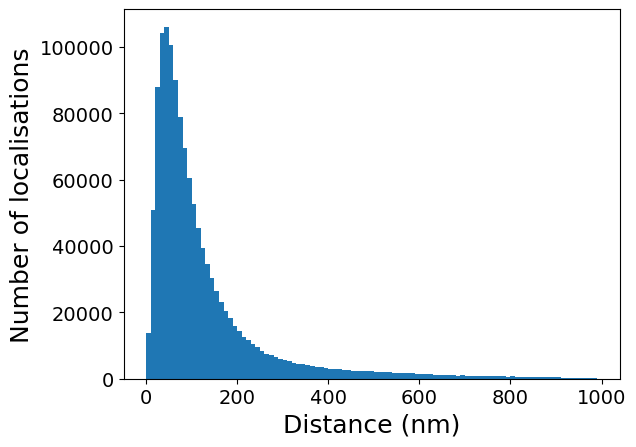

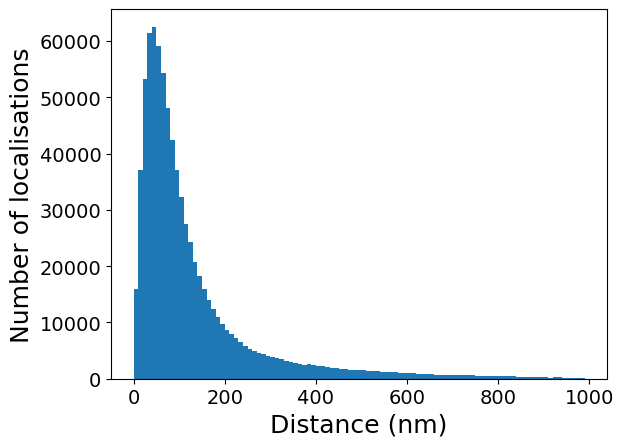

In [144]:
list_of_thresholds = list(range(0, 1000, 10))
create_histogram(list_of_thresholds, dict_sorted_by_vesicle_type['DEP'])
create_histogram(list_of_thresholds, dict_sorted_by_vesicle_type['SPON'])



t_stat: 18.063647248491563 p-value: 6.241364566597405e-73
DescribeResult(nobs=1279041, minmax=(0.28814059068307274, 999.9937948592479), mean=127.66667163231843, variance=19749.224208501495, skewness=2.7348702156690283, kurtosis=8.891811025567915)
DescribeResult(nobs=797134, minmax=(0.1114809400709991, 999.9865606976945), mean=131.35258172127374, variance=21566.718432057365, skewness=2.5898265463056434, kurtosis=7.763970341800922)


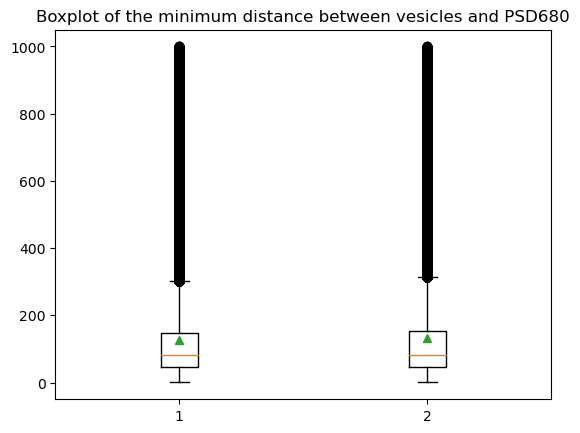

In [162]:
#threshold of the maximum distance to plot. Set to 1000 nm since this is about the size of a synapse
threshold=1000

DEP = dict_sorted_by_vesicle_type['DEP'][(dict_sorted_by_vesicle_type['DEP']<threshold)]
SPON = dict_sorted_by_vesicle_type['SPON'][(dict_sorted_by_vesicle_type['SPON']<threshold)]

plt.boxplot((DEP, SPON), showmeans=True)
plt.title(f'Boxplot of the minimum distance between vesicles and {target_marker}')

t_stat, p_value = sc.ttest_ind(SPON, DEP)
print('t_stat:', t_stat, 'p-value:', p_value)

DEP_stats = sc.describe(DEP)
SPON_stats = sc.describe(SPON)

print(DEP_stats)
print(SPON_stats)

In [168]:
import cv2